### Andrew Time-Series Analysis Notebook 11.2.2024
#### Notes:


In [1]:
import sys
!{sys.executable} -m pip install auto_ts scikit-learn statsmodels

In [2]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
import os
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

In [3]:
# Load 22 and 23 data
df_filled_22 = pd.read_pickle(r'D:\capstone_F24\data\Cleaned_data\df_filled_22.pkl')
df_filled_23 = pd.read_pickle(r'D:\capstone_F24\data\Cleaned_data\df_filled_23.pkl')


In [5]:
df_filled_22

timestamp,2022-02-01 00:00:00,2022-02-01 01:00:00,2022-02-01 02:00:00,2022-02-01 03:00:00,2022-02-01 04:00:00,2022-02-01 05:00:00,2022-02-01 06:00:00,2022-02-01 07:00:00,2022-02-01 08:00:00,2022-02-01 09:00:00,...,2022-12-31 14:00:00,2022-12-31 15:00:00,2022-12-31 16:00:00,2022-12-31 17:00:00,2022-12-31 18:00:00,2022-12-31 19:00:00,2022-12-31 20:00:00,2022-12-31 21:00:00,2022-12-31 22:00:00,2022-12-31 23:00:00
station_complex_id,,,,,,,,,,,,,,,,,,,,,
1,17.0,5.0,6.0,12.0,44.0,143.0,405.0,735.0,950.0,512.0,...,426.0,402.0,304.0,338.0,322.0,350.0,309.0,293.0,168.0,75.0
10,100.0,24.0,7.0,8.0,8.0,14.0,43.0,98.0,175.0,182.0,...,3.0,4.0,4.0,4.0,3.0,4.0,5.0,8.0,5.0,2.0
100,10.0,3.0,0.0,3.0,5.0,17.0,46.0,68.0,106.0,66.0,...,68.0,69.0,69.0,55.0,58.0,61.0,67.0,52.0,56.0,25.0
101,26.0,10.0,9.0,3.0,20.0,49.0,124.0,245.0,394.0,247.0,...,286.0,316.0,332.0,269.0,239.0,246.0,239.0,209.0,179.0,104.0
118,21.0,11.0,9.0,3.0,1.0,9.0,14.0,61.0,75.0,54.0,...,249.0,279.0,245.0,245.0,287.0,273.0,278.0,281.0,245.0,115.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,6.0,2.0,5.0,6.0,24.0,85.0,135.0,296.0,298.0,196.0,...,227.0,147.0,160.0,143.0,172.0,183.0,170.0,151.0,116.0,62.0
96,11.0,4.0,4.0,7.0,15.0,58.0,113.0,214.0,244.0,169.0,...,194.0,153.0,112.0,128.0,137.0,175.0,181.0,153.0,128.0,61.0
97,13.0,12.0,8.0,10.0,39.0,91.0,229.0,357.0,472.0,317.0,...,276.0,247.0,231.0,198.0,261.0,234.0,314.0,243.0,180.0,83.0


In [6]:
# Define a function to calculate symmetric mean absolute percentage error
def symmetric_mape(y_true, y_pred):
    return np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred))) * 100


In [7]:
# Parameters
batch_size = 10  # Set the number of stations to process per batch
predictions_file = 'df_23_pred.pkl'
metrics_file = 'df_timeseries_metrics.pkl'

In [8]:
# Initialize or load DataFrames for predictions and metrics
if os.path.exists(predictions_file):
    df_23_pred = pd.read_pickle(predictions_file)
else:
    df_23_pred = pd.DataFrame(columns=['station_complex_id', 'predicted_ridership_2023'])

if os.path.exists(metrics_file):
    df_timeseries_metrics = pd.read_pickle(metrics_file)
else:
    df_timeseries_metrics = pd.DataFrame(columns=['station_complex_id', 'rmse', 'mae', 'smape'])

In [9]:
# Total number of stations for tracking progress
total_stations = len(df_filled_22.index)
start_idx = len(df_23_pred)  # Continue from where the last batch stopped

# Process each batch of stations
for idx in range(start_idx, total_stations, batch_size):
    batch_end = min(idx + batch_size, total_stations)
    print(f"Processing stations {idx + 1} to {batch_end} ({(batch_end / total_stations) * 100:.2f}% complete)")

    # Temporary lists to store batch results before concatenation
    batch_pred = []
    batch_metrics = []

    # Process each station in the batch
    for station_id in df_filled_22.index[idx:batch_end]:
        # Extract the time series for this station from 2022 and 2023 data
        train_data = df_filled_22.loc[station_id].transpose().reset_index()
        train_data.columns = ['transit_timestamp', 'ridership']
        test_data = df_filled_23.loc[station_id].transpose().reset_index()
        test_data.columns = ['transit_timestamp', 'ridership']
        
        # Convert 'transit_timestamp' to datetime and set it as the index
        train_data['transit_timestamp'] = pd.to_datetime(train_data['transit_timestamp'])
        test_data['transit_timestamp'] = pd.to_datetime(test_data['transit_timestamp'])
        train_data.set_index('transit_timestamp', inplace=True)
        test_data.set_index('transit_timestamp', inplace=True)
        
        # Initialize and train the SARIMA model on 2022 data
        model = SARIMAX(
            train_data['ridership'],
            order=(1, 1, 1),  # Non-seasonal ARIMA order (p, d, q)
            seasonal_order=(1, 1, 1, 24),  # Seasonal order (P, D, Q, s) with daily seasonality
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        results = model.fit(disp=False)
        
        # Forecast for the length of the test data
        forecast = results.get_forecast(steps=len(test_data))
        forecast_values = forecast.predicted_mean

        # Add predictions to batch results
        batch_pred.append({
            'station_complex_id': station_id,
            'predicted_ridership_2023': forecast_values.tolist()
        })
        
        # Compute metrics
        rmse = np.sqrt(mean_absolute_error(test_data['ridership'], forecast_values)**2)  # RMSE
        mae = mean_absolute_error(test_data['ridership'], forecast_values)
        smape = symmetric_mape(test_data['ridership'], forecast_values)
        
        # Add metrics to batch results
        batch_metrics.append({
            'station_complex_id': station_id,
            'rmse': rmse,
            'mae': mae,
            'smape': smape
        })

    # Concatenate batch results with main DataFrames
    df_23_pred = pd.concat([df_23_pred, pd.DataFrame(batch_pred)], ignore_index=True)
    df_timeseries_metrics = pd.concat([df_timeseries_metrics, pd.DataFrame(batch_metrics)], ignore_index=True)

    # Save the current state of predictions and metrics DataFrames
    df_23_pred.to_pickle(predictions_file)
    df_timeseries_metrics.to_pickle(metrics_file)
    print(f"Batch {idx + 1} to {batch_end} saved to pickle.")

In [ ]:
# Save metrics and predictions as desired
df_23_pred.to_pickle('df_23_pred.pkl')
df_timeseries_metrics.to_pickle('df_timeseries_metrics.pkl')


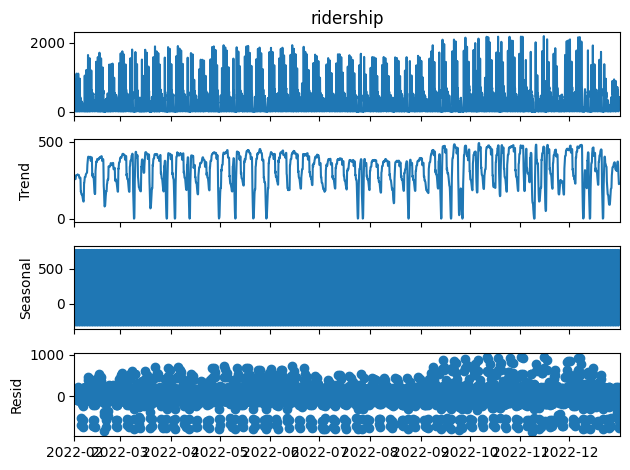

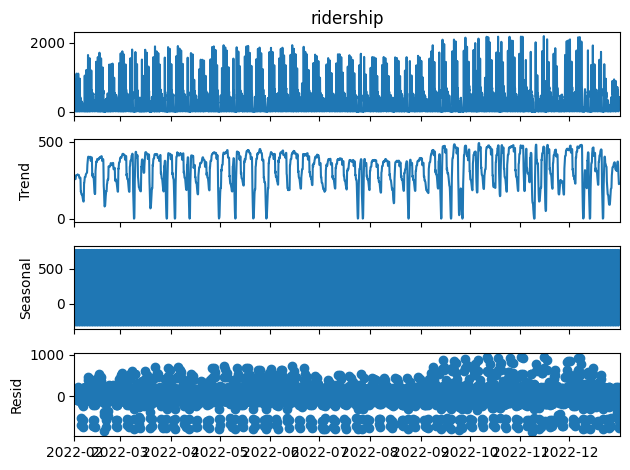

In [10]:
# Decomposition for Seasonality (optional example for one station)
station_example = df_filled_22.loc[df_filled_22.index[0]].transpose().reset_index()
station_example.columns = ['transit_timestamp', 'ridership']
station_example['transit_timestamp'] = pd.to_datetime(station_example['transit_timestamp'])
station_example.set_index('transit_timestamp', inplace=True)

decomposition = sm.tsa.seasonal_decompose(station_example['ridership'], model='additive', period=24)
decomposition.plot()

In [13]:
df_timeseries_metrics

,station_complex_id,rmse,mae,smape
0,1,165.137938,165.137938,51.528270
1,10,249.379695,249.379695,55.338124
2,100,28.173102,28.173102,60.163773
3,101,141.345875,141.345875,77.205690
4,118,65.380958,65.380958,52.849263
...,...,...,...,...
356,95,138.559805,138.559805,81.402249
357,96,43.393786,43.393786,31.990164
358,97,292.582292,292.582292,149.725284
359,98,81.345115,81.345115,87.398412
